# Grupo:

#### Alessandro de Freitas Guerreiro - 11233891
#### Matheus Yasuo Ribeiro Utino - 11233689
#### Vinícius Silva Montanari - 11233709

## Tema: Classificação por imagens da patologia retinopatia diabética utilizando técnicas de aprendizado de máquina
### Universidade de São Paulo
### Instituto de Ciências Matemáticas e de Computação (ICMC)
### SCC0276 - Aprendizado de Máquina (2022)

In [1]:
# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
import keras
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

In [2]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 448.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Data Analysis

In [3]:
#Define path of files

KAGGLE_DIR = '../input/aptos2019-blindness-detection/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"

In [4]:
#Load csv and convert to pandas dataframe

df_train = pd.read_csv(TRAIN_DF_PATH)
df_train['id_code'] = df_train['id_code'] + ".png"

In [5]:
#Show train dataset shape and informations

print("Train dataset size :", df_train.shape, "\n")
df_train.head()

Train dataset size : (3662, 2) 



,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [6]:
#Get number of occurrences of each class in train dataset

df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


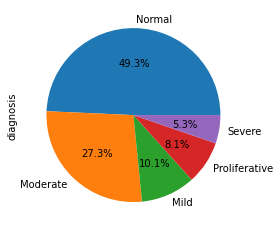

In [7]:
#Pie graph for classes in train dataset

df_train['diagnosis'].value_counts().plot(labels = ['Normal', 'Moderate', 'Mild', 'Proliferative', 'Severe'],kind = 'pie',autopct='%1.1f%%')
plt.savefig('pie_train_classes.png', dpi = 400)
plt.show() 

In [8]:
# Remove duplicated lines in dataframes
df_train = df_train.drop_duplicates()
print("Train dataset size :", df_train.shape, "\n")

# Analysis Nan values in dataframes
print("There are Nan in train dataset? ", bool(df_train.isnull().sum().sum()), "\n")

Train dataset size : (3662, 2) 

There are Nan in train dataset?  False 



Shape of Image: (1736, 2416, 3)
Shape of Image: (1958, 2588, 3)
Shape of Image: (1424, 2144, 3)
Shape of Image: (1736, 2416, 3)
Shape of Image: (2588, 3388, 3)


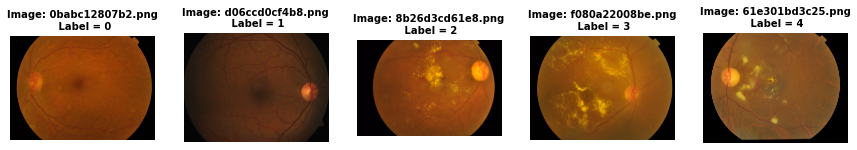

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot one figure for each class in dataframe

fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = df_train[df_train['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = mpimg.imread('../input/aptos2019-blindness-detection/train_images/' + image_name)
    print("Shape of Image: " + str(X.shape))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);
plt.savefig('real_images.png', dpi = 200)

# Preprocessing

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import *
from keras.models import Sequential, load_model
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.layers.core import Dense
import tensorflow.keras as keras
from tensorflow.keras.applications import EfficientNetB3

#Define some constants about the images

IMG_WIDTH = 320
IMG_HEIGHT = 320
NUM_DIMENSIONS = 3
BATCH_SIZE = 1

INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, NUM_DIMENSIONS)

#Building a cnn for features extraction using fine tunning

efnb3 = EfficientNetB3(weights='imagenet', include_top = False, input_shape = INPUT_SHAPE)

model = Sequential()
model.add(efnb3)
model.add(GlobalAveragePooling2D())

model.summary()


2022-06-02 03:27:36.763287: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
Total params: 10,783,535
Trainable params: 10,696,232
Non-trainable params: 87,303
_________________________________________________________________


In [11]:
# Image Data Generator

train_datagen = ImageDataGenerator()

# Resize and load image

train_generator = train_datagen.flow_from_dataframe(df_train, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    seed=42,
                                                    class_mode='raw', 
                                                    subset='training')


Found 3662 validated image filenames.


In [12]:
# Generate data

def generateData(generator, numElements):
    x = []
    y = []
        
    for j in tqdm(range(0, numElements)):
        img, label = next(generator)
        x.append(model.predict(img))
        y.append(label)
            
    return np.array(x),np.array(y)

In [13]:
print('Generating train dataset!')
x_train, y_train = generateData(train_generator, len(train_generator))

Generating train dataset!


100%|██████████| 3662/3662 [21:12<00:00,  2.88it/s]


In [14]:
x_train.shape

(3662, 1, 1536)

In [15]:
y_train.shape

(3662, 1)

In [16]:
#Change dimension (numElements, 1, IMG_WIDTH, IMG_HEIGHT, NUM_DIMENSIONS) to (numElements, IMG_WIDTH, IMG_HEIGHT, NUM_DIMENSIONS)
x_train = np.array(np.squeeze(x_train, axis = 1))

#Change dimension (numElements, 1) to (numElements)
y_train = np.ravel(y_train)

In [17]:
#Generate train, validate and test 

from sklearn.model_selection import train_test_split

x_train_2, x_test, y_train_2, y_test = train_test_split(x_train, y_train, test_size=0.15, stratify=y_train, shuffle = True, random_state=42)

x_train_final, x_val, y_train_final, y_val = train_test_split(x_train_2, y_train_2, test_size=0.2, stratify=y_train_2, shuffle = True, random_state=42)

In [18]:
from imblearn.over_sampling import SMOTE

# Using Synthetic Minority Oversampling Technique (SMOTE) to balance dataset

sm = SMOTE(random_state=42)
x_train_SMOTE, y_train_SMOTE = sm.fit_resample(x_train_final, y_train_final)

In [19]:
from imblearn.over_sampling import RandomOverSampler 

# Using RandomOverSampler to balance dataset

sm = RandomOverSampler(random_state=42)
x_train_ROV, y_train_ROV = sm.fit_resample(x_train_final, y_train_final)

In [20]:
from imblearn.over_sampling import BorderlineSMOTE

# Using BorderlineSMOTE to balance dataset

sm = BorderlineSMOTE(random_state = 42)
x_train_BLM, y_train_BLM = sm.fit_resample(x_train_final, y_train_final)

In [21]:
from imblearn.over_sampling import ADASYN 

# Using ADASYN  to balance dataset

sm = ADASYN(random_state=42)
x_train_ADASYN, y_train_ADASYN = sm.fit_resample(x_train_final, y_train_final)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Get results of validate and test dataset

def getResults(nameClassifier, nameDataAugmentation, x_train, y_train, x_val, y_val, x_test, y_test):
    
    print("Using ", nameClassifier, "and", nameDataAugmentation, "data augmentation technic\n\n")
    
    results_val = []
    if(nameClassifier == "KNN"):
        for K in range(2, 13):
            for weight in ['uniform','distance']:
                clf = KNeighborsClassifier(n_neighbors = K, weights = weight)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_val)
                results_val.append([K, weight, accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro'), cohen_kappa_score(y_val, y_pred, weights = 'quadratic')])
                
    elif(nameClassifier == "Decision Tree"):
        for max_depth in range(2, 11):
            for criterion in ['gini', 'entropy']:
                clf = DecisionTreeClassifier(max_depth = max_depth, criterion = criterion, random_state = 42)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_val)
                results_val.append([max_depth, criterion, accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro'), cohen_kappa_score(y_val, y_pred, weights = 'quadratic')])
    
    elif(nameClassifier == "SVM"): 
        for C in [10, 100, 1000]:
            for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
                clf = svm.SVC(C = C, kernel = kernel, random_state = 42)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_val)
                results_val.append([C, kernel, accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='macro'), cohen_kappa_score(y_val, y_pred, weights = 'quadratic')])
        
    print("Results of validate:\n")
    for i in results_val:
        print(i)
    print("\n")
    
    
    max = results_val[0][4]
    index_max = 0
    # Search max cohen kappa score
    for i in range(1,len(results_val)):
        if(results_val[i][4] > max):
            max = results_val[i][4]
            index_max = i
    
    print("Best validate results and params:",results_val[index_max])
    
    results_test = []
    
    if(nameClassifier == "KNN"):
        clf = KNeighborsClassifier(n_neighbors = results_val[index_max][0], weights = results_val[index_max][1])
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results_test.append([results_val[index_max][0], results_val[index_max][1], accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), cohen_kappa_score(y_test, y_pred, weights = 'quadratic')])
        
    elif(nameClassifier == "Decision Tree"):
        clf = DecisionTreeClassifier(max_depth = results_val[index_max][0], criterion = results_val[index_max][1], random_state = 42)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results_test.append([results_val[index_max][0], results_val[index_max][1], accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), cohen_kappa_score(y_test, y_pred, weights = 'quadratic')])
        
    elif(nameClassifier == "SVM"): 
        clf = svm.SVC(C = results_val[index_max][0], kernel = results_val[index_max][1], random_state = 42)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results_test.append([results_val[index_max][0], results_val[index_max][1], accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), cohen_kappa_score(y_test, y_pred, weights = 'quadratic')]) 
        
    print("Result of test:",results_test)
    print("\n\n\n")

# K-Nearest Neighbors (KNN)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

getResults("KNN", "Nothing", x_train_final, y_train_final, x_val, y_val, x_test, y_test)
getResults("KNN", "Synthetic Minority Oversampling Technique (SMOTE)",  x_train_SMOTE, y_train_SMOTE, x_val, y_val, x_test, y_test)
getResults("KNN", "RandomOverSampler", x_train_ROV, y_train_ROV, x_val, y_val, x_test, y_test)
getResults("KNN", "BorderlineSMOTE",  x_train_BLM, y_train_BLM, x_val, y_val, x_test, y_test)
getResults("KNN", "ADASYN", x_train_ADASYN, y_train_ADASYN, x_val, y_val, x_test, y_test)

Using  KNN and Nothing data augmentation technic


Results of validate:

[2, 'uniform', 0.7271268057784912, 0.4417260617853612, 0.7435418772784363]
[2, 'distance', 0.7415730337078652, 0.5384159270593273, 0.7693173571100612]
[3, 'uniform', 0.7431781701444623, 0.46580915488805025, 0.7463616171826819]
[3, 'distance', 0.7560192616372392, 0.5218734399701372, 0.7904541402092862]
[4, 'uniform', 0.7592295345104334, 0.4912971999422928, 0.7845262296137536]
[4, 'distance', 0.7608346709470305, 0.5101089532057023, 0.8022347787442068]
[5, 'uniform', 0.7624398073836276, 0.47242692410921894, 0.7731674316433077]
[5, 'distance', 0.7688603531300161, 0.5115215719611583, 0.8036787876642]
[6, 'uniform', 0.7656500802568218, 0.4793307347900523, 0.7832139442909338]
[6, 'distance', 0.7704654895666132, 0.5093206614553132, 0.7963111575864184]
[7, 'uniform', 0.7640449438202247, 0.45829664937264036, 0.7885528440729676]
[7, 'distance', 0.7720706260032103, 0.496457471441803, 0.8151627833379484]
[8, 'uniform', 0.77367

# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

getResults("Decision Tree", "Nothing", x_train_final, y_train_final, x_val, y_val, x_test, y_test)
getResults("Decision Tree", "Synthetic Minority Oversampling Technique (SMOTE)", x_train_SMOTE, y_train_SMOTE, x_val, y_val, x_test, y_test)
getResults("Decision Tree", "RandomOverSampler", x_train_ROV, y_train_ROV, x_val, y_val, x_test, y_test)
getResults("Decision Tree", "BorderlineSMOTE", x_train_BLM, y_train_BLM, x_val, y_val, x_test, y_test)
getResults("Decision Tree", "ADASYN", x_train_ADASYN, y_train_ADASYN, x_val, y_val, x_test, y_test)

Using  Decision Tree and Nothing data augmentation technic


Results of validate:

[2, 'gini', 0.6886035313001605, 0.29884751392289083, 0.598690089660719]
[2, 'entropy', 0.666131621187801, 0.3070299894284602, 0.635505816875314]
[3, 'gini', 0.7191011235955056, 0.3647509300058491, 0.7277074257927261]
[3, 'entropy', 0.7126805778491172, 0.31590713208360266, 0.7388398131140295]
[4, 'gini', 0.723916532905297, 0.37901475226130477, 0.7598584175754937]
[4, 'entropy', 0.7142857142857143, 0.37395560635087555, 0.74316533155997]
[5, 'gini', 0.7303370786516854, 0.4138827585643418, 0.7645447716276053]
[5, 'entropy', 0.7255216693418941, 0.4539123638270489, 0.7679669437749028]
[6, 'gini', 0.7271268057784912, 0.4667470325756827, 0.7486628660822505]
[6, 'entropy', 0.6966292134831461, 0.44320362383562084, 0.7312566481813939]
[7, 'gini', 0.7174959871589085, 0.47321109197925626, 0.7314944510289839]
[7, 'entropy', 0.6934189406099518, 0.4475488285560053, 0.7171349943245384]
[8, 'gini', 0.7287319422150883, 0.4

# Support Vector Machines (SVM)

In [25]:
from sklearn import svm

getResults("SVM", "Nothing", x_train_final, y_train_final, x_val, y_val, x_test, y_test)
getResults("SVM", "Synthetic Minority Oversampling Technique (SMOTE)",  x_train_SMOTE, y_train_SMOTE, x_val, y_val, x_test, y_test)
getResults("SVM", "RandomOverSampler", x_train_ROV, y_train_ROV, x_val, y_val, x_test, y_test)
getResults("SVM", "BorderlineSMOTE",  x_train_BLM, y_train_BLM, x_val, y_val, x_test, y_test)
getResults("SVM", "ADASYN", x_train_ADASYN, y_train_ADASYN, x_val, y_val, x_test, y_test)

Using  SVM and Nothing data augmentation technic


Results of validate:

[10, 'linear', 0.797752808988764, 0.6133721376915101, 0.8721977549986858]
[10, 'poly', 0.8218298555377207, 0.6326302773850545, 0.880552182527002]
[10, 'rbf', 0.8298555377207063, 0.6462966826650732, 0.8888822522695164]
[10, 'sigmoid', 0.7640449438202247, 0.5232992603673232, 0.8265153637416534]
[100, 'linear', 0.7913322632423756, 0.5947637740861388, 0.8635410058425639]
[100, 'poly', 0.8138041733547352, 0.6291580935216347, 0.8870104086648326]
[100, 'rbf', 0.8218298555377207, 0.6499814040330121, 0.8844698779924924]
[100, 'sigmoid', 0.7367576243980738, 0.5299184126112715, 0.785128020047791]
[1000, 'linear', 0.797752808988764, 0.6015285536630847, 0.8564713123105265]
[1000, 'poly', 0.8057784911717496, 0.61139051090243, 0.8747685266851708]
[1000, 'rbf', 0.8234349919743178, 0.6495695090664, 0.8829165527978091]
[1000, 'sigmoid', 0.7223113964686998, 0.514185966559895, 0.7913669377636672]


Best validate results and params: [